In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mayavi import mlab
from tvtk.tools import visual
from scipy import interpolate
import math
from numpy import unravel_index
import pickle
from datalib import Data
from mayavi import mlab
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
import healpy as hp
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

In [3]:
def numerically_find_flow_line_3d(starting_point, step, opfl):
    func_x = []
    func_y = []
    func_z = []
    
    x = starting_point[0]
    y = starting_point[1]
    z = starting_point[2]
    
    x0 = starting_point[0]
    y0 = starting_point[1]
    z0 = starting_point[2]
    
    edge = 20
    
    while True:
        func_x.append(x)
        func_y.append(y)
        func_z.append(z)
        coords=np.stack((z,y,x),axis=-1)
        delta_x = Bxf((coords))[0]
        delta_y = Byf((coords))[0]
        delta_z = Bzf((coords))[0]
        magnitude = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)
        delta_x = delta_x / magnitude * step
        delta_y = delta_y / magnitude * step
        delta_z = delta_z / magnitude * step
        x = x + delta_x
        y = y + delta_y
        z = z + delta_z
        r = np.sqrt(x**2+y**2+z**2)
        rr = np.sqrt(x**2+y**2)
        if x>edge or x<-edge or y>edge or y<-edge or z>edge or z<-edge or np.isnan(x) or np.isnan(y) or np.isnan(z) or rr>edge:
            opfl.append([x0,y0,z0])
            break
        if r<=2.0:
            break
       
    while True:
        func_x.append(x)
        func_y.append(y)
        func_z.append(z)
        coords=np.stack((z,y,x),axis=-1)
        delta_x = Bxf((coords))[0]
        delta_y = Byf((coords))[0]
        delta_z = Bzf((coords))[0]
        magnitude = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)
        delta_x = delta_x / magnitude * step
        delta_y = delta_y / magnitude * step
        delta_z = delta_z / magnitude * step
        x = x - delta_x
        y = y - delta_y
        z = z - delta_z
        r = np.sqrt(x**2+y**2+z**2)
        rr = np.sqrt(x**2+y**2)
        if x>edge or x<-edge or y>edge or y<-edge or z>edge or z<-edge or np.isnan(x) or np.isnan(y) or np.isnan(z) or rr>edge:
            opfl.append([x0,y0,z0])
            break
        if r<=2.0:
            break
    
    return func_x, func_y, func_z, opfl

In [4]:
def cal_field(vacuum, multipole):
   
    T = 4.188
    omega = 2*np.pi/T
    c = 3e10
    ini_ph = 0.05*210%(2*np.pi)*180/np.pi
    
    if vacuum:
        if multipole:
            with open("Bx_v.pkl","rb") as f1:
                data_bx = pickle.load(f1)

            with open("By_v.pkl","rb") as f2:
                data_by = pickle.load(f2)
    
            with open("Bz_v.pkl","rb") as f3:
                data_bz = pickle.load(f3)
    
        else:
            with open("Bx_v_dip.pkl","rb") as f1:
                data_bx = pickle.load(f1)

            with open("By_v_dip.pkl","rb") as f2:
                data_by = pickle.load(f2)
    
            with open("Bz_v_dip.pkl","rb") as f3:
                data_bz = pickle.load(f3)
        
    
        w=20
        N1 = len(data_bx)
        x0 = np.linspace(-w,w,N1)
        y0 = np.linspace(-w,w,N1)
        z0 = np.linspace(-w,w,N1)
        center = int(N1/2.0)


    else:
        data_bx = np.transpose(data.Bx,(0,1,2))
        data_by = np.transpose(data.By,(0,1,2))
        data_bz = np.transpose(data.Bz,(0,1,2))
        nz,ny,nx = data_bx.shape
        xmin=conf['lower'][0] 
        ymin=conf['lower'][1]
        zmin=conf['lower'][2]
        sizex=conf['size'][0]
        sizey=conf['size'][1]
        sizez=conf['size'][2]
        xmax=xmin+sizex
        ymax=ymin+sizey
        zmax=zmin+sizez
        dx=sizex/nx
        dy=sizey/ny
        dz=sizez/nz
        x0 = np.linspace(-60,60,nx)
        y0 = np.linspace(-60,60,ny)
        z0 = np.linspace(-60,60,nz)
        center = int(len(data_bx)/2.0)

    
    
    Bx = data_bx
    By = data_by
    Bz = data_bz
    Bmag = np.sqrt(Bx**2+By**2+Bz**2)
    Bx = Bx/Bmag
    By = By/Bmag
    Bz = Bz/Bmag
    Bxf=RegularGridInterpolator((z0,y0,x0),Bx)
    Byf=RegularGridInterpolator((z0,y0,x0),By)
    Bzf=RegularGridInterpolator((z0,y0,x0),Bz)
             
    return Bxf,Byf,Bzf

In [5]:
@jit(parallel=True)
def openfieldlines2(x, y, z, step, edge):

    opfl = []
    
    x0 = x
    y0 = y
    z0 = z
    c1 = 0
    c2 = 0
    
    while True:
        c1+=1
        coords=np.stack((z,y,x),axis=-1)
        delta_x = Bxf((coords))[0]
        delta_y = Byf((coords))[0]
        delta_z = Bzf((coords))[0]
        magnitude = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)
        delta_x = delta_x / magnitude * step
        delta_y = delta_y / magnitude * step
        delta_z = delta_z / magnitude * step
        x = x + delta_x
        y = y + delta_y
        z = z + delta_z
        r = np.sqrt(x**2+y**2)
        rr = np.sqrt(x**2+y**2+z**2)
        #print (r,rr)
        if r>=edge:
            #print (r, starting_point)
            #opfl.append([x0,y0,z0])
            break
        if rr<3:
            opfl.append([x,y,z])
            break
        if c1>1000:
            break
            
    while True:
        c2+=1
        coords=np.stack((z,y,x),axis=-1)
        delta_x = Bxf((coords))[0]
        delta_y = Byf((coords))[0]
        delta_z = Bzf((coords))[0]
        magnitude = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)
        delta_x = delta_x / magnitude * step
        delta_y = delta_y / magnitude * step
        delta_z = delta_z / magnitude * step
        x = x - delta_x
        y = y - delta_y
        z = z - delta_z
        r = np.sqrt(x**2+y**2)
        rr = np.sqrt(x**2+y**2+z**2)
        if r>=edge:
            #print (r,starting_point)
            #opfl.append([x0,y0,z0])
            break
        if rr<3:# or rr>=edge:
            opfl.append([x,y,z])
            break
        if c2>1000:
            break
    
    return opfl

In [6]:
datadir='.'
data=Data(datadir)
conf = data._conf

T = 4.188
omega = 2*np.pi/T
omega_p = omega*0.1/3.0
c = 3e10
ini_ph = 0.05*210%(2*np.pi)*180/np.pi
print (ini_ph)

nz,ny,nx = data.Bx.shape
xmin=conf['lower'][0] 
ymin=conf['lower'][1]
zmin=conf['lower'][2]
sizex=conf['size'][0]
sizey=conf['size'][1]
sizez=conf['size'][2]
xmax=xmin+sizex
ymax=ymin+sizey
zmax=zmin+sizez
dx=sizex/nx
dy=sizey/ny
dz=sizez/nz
x0 = np.linspace(xmin,xmax,nx)
y0 = np.linspace(ymin,ymax,ny)
z0 = np.linspace(zmin,zmax,nz)

241.6056848873644


In [7]:
x1,y1,z1=np.meshgrid(x0,y0,z0,indexing='ij')
x1=np.transpose(x1,(2,1,0))
y1=np.transpose(y1,(2,1,0))
z1=np.transpose(z1,(2,1,0))
vx=-omega*y1
vy=omega*x1
vz=0
chx=data.Jx-data.divE*vx
chy=data.Jy-data.divE*vy
chz=data.Jz-data.divE*vz
ll=(chx*data.Bx+chy*data.By+chz*data.Bz)/(data.Bx**2+data.By**2+data.Bz**2)

In [8]:
llf=RegularGridInterpolator((z0,y0,x0),ll)

In [9]:
r_em = 20
th,ph = np.mgrid[0.01:np.pi:80j, 0.01:2*np.pi:80j]
#th,ph = np.mgrid[130*np.pi/180:np.pi*140/180:100j, 50*np.pi/180:300*np.pi/180:100j]
xsurf = r_em*np.sin(th)*np.cos(ph)
ysurf = r_em*np.sin(th)*np.sin(ph)
zsurf = r_em*np.cos(th)

In [10]:
p1 = xsurf.flatten()
p2 = ysurf.flatten()
p3 = zsurf.flatten()
coords=np.stack((p3,p2,p1),axis=-1)
Lam = (llf(coords))

In [11]:
Bxf, Byf, Bzf = cal_field(False, True)

id1 = np.where(np.logical_or(Lam>0.06,Lam<-0.06))
ids = id1[0]

pp1 = p1[ids]
pp2 = p2[ids]
pp3 = p3[ids]

print (len(pp1))

5985


In [12]:
def rescale_phi(phi):
    n_id = np.where(phi<0)[0]
    phi[n_id] = phi[n_id]+2*np.pi
    return phi

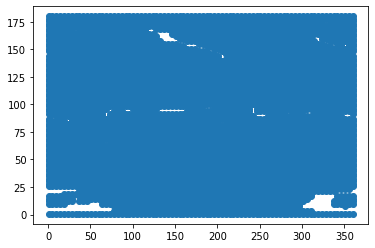

In [13]:
rr = np.sqrt(pp1**2+pp2**2+pp3**2)
th_points = np.arccos(pp3/rr)
phi_points = np.arctan2(pp2,pp1)
phi_points = rescale_phi(phi_points)
plt.scatter(phi_points*180/np.pi,th_points*180/np.pi)
#plt.xlim(0,360)
#plt.ylim(130,140)

In [14]:
#dir = "Data/Multipole/"
pp1 = np.array(pp1)
pp2 = np.array(pp2)
pp3 = np.array(pp3)
#np.savetxt(dir+"openfieldlines_rem_%s.txt"%str(r_em),np.c_[pp1,pp2,pp3])

In [15]:
#pp1, pp2, pp3 = np.genfromtxt("FF_open_12rem.txt", unpack=True)
#print (len(pp1))
#rr = np.sqrt(pp1**2+pp2**2+pp3**2)
#th_points = np.arccos(pp3/rr)
#phi_points = np.arctan(pp2/pp1)
#plt.scatter(phi_points,th_points)

In [16]:
#for i in range(0,len(pp1),1):
x_em_points = []
y_em_points = []
z_em_points = []

list1 = range(len(p1))
#list2 = range(800,len(pp1),1)
#tot_list = [*list1,*list2]


for i in list1:
    
    print (i)

    try:
        poi = openfieldlines2(p1[i], p2[i], p3[i], 0.1, 20)
        print (poi)
        x_em_points.append(poi[0][0])
        y_em_points.append(poi[0][1])
        z_em_points.append(poi[0][2])
        if len(poi)>1:
            x_em_points.append(poi[1][0])
            y_em_points.append(poi[1][1])
            z_em_points.append(poi[1][2])
    
    except:
        pass
    
x_em_points = np.array(x_em_points)
y_em_points = np.array(y_em_points)
z_em_points = np.array(z_em_points)

0


/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_18221/674871343.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "openfieldlines2" failed type inference due to: Untyped global name 'Bxf': Cannot determine Numba type of <class 'scipy.interpolate.interpolate.RegularGridInterpolator'>

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_18221/674871343.py", line 15:
<source missing, REPL/exec in use?>

  @jit(parallel=True)
/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "openfieldlines2" was compiled in object mode without forceobj=True.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_18221/674871343.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-b

[[1.6296032096285937, -2.3363164645337005, 0.7396103302831523]]
1
[[1.6462190914102486, -2.3560858336286246, 0.7868217109294218]]
2
[[1.6245140827942792, -2.332551238819706, 0.734743053755849]]
3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
15
[]
16
[]
17
[]
18
[]
19
[]
20
[]
21
[]
22
[]
23
[]
24
[]
25
[]
26
[]
27
[]
28
[]
29
[[1.6479822940299653, -2.3490565428624866, 0.7597752203256865]]
30
[[1.6493378893390775, -2.3635723273649, 0.8146908641526388]]
31
[[1.6463925523627791, -2.3567890582157456, 0.7919054549283996]]
32
[[1.6382069816258764, -2.347962589874025, 0.7729445930720855]]
33
[]
34
[]
35
[]
36
[[1.6305263071439209, -2.357714818757857, 0.8590366689621451]]
37
[[1.6194739043664403, -2.343181250574979, 0.8109821973837913]]
38
[[1.6180451763762589, -2.3446815897626396, 0.83445051961232]]
39
[[1.6030389616301755, -2.3284392789994635, 0.7993691152345689]]
40
[[1.6223714972008674, -2.352541277510373, 0.8823993689732001]]
41
[[1.6266658428731913, -2.3488166823400265,

[[1.5234544934378578, -2.3947583419867398, 0.8955582008679479]]
253
[[1.520371745280199, -2.3728861164842394, 0.9207829457516447]]
254
[]
255
[]
256
[]
257
[]
258
[[1.5367553736072839, -2.3148014372133767, 1.1080916147221926]]
259
[]
260
[]
261
[]
262
[]
263
[[1.5619329254167216, -2.3983382231628627, 0.6807413342525613]]
264
[[-2.0451731199733034, 2.1146929387263476, -0.4259118482822718]]
265
[[-2.049760742911842, 2.0972387094848823, -0.41822922804496615]]
266
[[-2.0691304969310877, 2.088136638817424, -0.4027055704967435]]
267
[]
268
[[-2.1738301356775382, 1.9608212983097313, -0.33170542892199]]
269
[[-2.087208935737472, 1.9938002806330868, -0.3833656767588148]]
270
[[-2.2472974373296397, 1.9166299447818302, -0.2815298934855362]]
271
[[-2.1681148994177755, 1.9425169410184981, -0.33455742932469723]]
272
[[-2.065991627969063, 2.0666999736378417, -0.4040179381155672]]
273
[[1.5831816172574733, -2.400518014014687, 0.637352877701578]]
274
[]
275
[]
276
[]
277
[]
278
[]
279
[[1.5592303717132

[[-2.1618918826573137, 2.005886732123512, -0.3415041014737354]]
439
[[-2.2209417759522627, 1.9106060685371107, -0.3095888036315384]]
440
[[-2.1624697794257526, 1.942908173070617, -0.3373976409421025]]
441
[]
442
[[1.7758578655885378, -2.330483157336988, 0.42698615276295726]]
443
[[1.7318566108804205, -2.37296476451131, 0.45760575715140955]]
444
[]
445
[]
446
[[1.6343377269204884, -2.381774940637211, 0.5647700302485287]]
447
[]
448
[[1.5723903707568494, -2.3860525856876924, 0.7834191344312437]]
449
[]
450
[]
451
[]
452
[]
453
[]
454
[[1.6924442290325987, -2.3285337034906504, 0.7126689326677608]]
455
[]
456
[]
457
[]
458
[[1.7420905611496051, -2.218494671642732, 1.009010245827223]]
459
[[1.715462110302314, -2.2039985417038532, 0.9471563912403312]]
460
[[1.6539061841966889, -2.234300237484611, 0.9699488037648218]]
461
[[1.6836516138722253, -2.3057978828314933, 0.7646423084880744]]
462
[]
463
[[1.651058466650552, -2.3411058344928257, 0.8788215983414953]]
464
[[1.7794195018387946, -2.179919

[[-1.8842238973164027, 2.187378246460471, -0.5536362454803323]]
651
[]
652
[[-1.9394623399607436, 2.2143126800218207, -0.5186889905331556]]
653
[[1.6442295071161654, -2.3991067973285074, 0.4201288051260763]]
654
[[-1.881840178899475, 2.234581925106587, -0.5666763327645907]]
655
[[-1.8696783588178336, 2.2316387016996244, -0.5724430581567919]]
656
[[-1.9174510554436466, 2.209479752574085, -0.5230118192050616]]
657
[[-1.90882433590729, 2.19699003246242, -0.5250120633317423]]
658
[[-1.8813034453342852, 2.2037492882294223, -0.5478263708377558]]
659
[[-1.8809730627127397, 2.214822669066506, -0.547694628476071]]
660
[[-1.8809289528051825, 2.1737181885015877, -0.5355850960185974]]
661
[[-1.9555784914067669, 2.205509493586667, -0.4838345869419206]]
662
[[-1.9237739036573844, 2.1668575926397198, -0.4976628479192799]]
663
[[-1.9590990243976032, 2.214913491730461, -0.4808194224595783]]
664
[[-1.9743892643012, 2.1867740905777393, -0.462722731359517]]
665
[[-1.9734667966562784, 2.107401567288421, -0

[[-1.8781322154243074, 2.162996525982852, -0.5180416628149964], [1.641720323193429, -1.793384437992415, 1.7507827912374407]]
819
[[-1.866871789419357, 2.1769386827409987, -0.536234871501768]]
820
[[-1.8751414643601505, 2.207120038275853, -0.5442750667654686]]
821
[[-1.9021579150494676, 2.2090384894755917, -0.5279346368202705]]
822
[[-1.8915721403372396, 2.1597260290414186, -0.5219282805062826]]
823
[[-1.9633027940750676, 2.2086517840229822, -0.47936070785347334]]
824
[[-1.9613910962319168, 2.151246985838848, -0.4678897452426138]]
825
[[-1.9719830596333348, 2.1208012225544666, -0.4530756071184758]]
826
[[-2.003204095528703, 2.114982737757779, -0.43185701252351627]]
827
[[-2.0277186080443688, 2.1117091877218077, -0.4142522588773311]]
828
[[-2.06568839550179, 2.094872099739888, -0.39401693304518226]]
829
[[-2.0883114292757305, 2.1032560678630863, -0.3787226646402086]]
830
[[-2.0970760857634563, 2.0510859027721704, -0.36836069739825705]]
831
[[-2.0979283599759877, 1.994213039692083, -0.360

[[2.3892293307248385, -1.5661479276038306, 0.8379278480090814]]
955
[[2.4023033953977198, -1.5223068349341746, 0.8722336453472912]]
956
[[2.408831654555595, -1.48314986689, 0.9198564769384036]]
957
[[2.407913464159798, -1.4483667619737912, 0.9822129331898233]]
958
[[2.398905213449974, -1.417057642065749, 1.05887105648276]]
959
[[2.3786199370098884, -1.3876591426770999, 1.1513174305009157]]
960
[[2.4957146941905246, -1.2614906225114502, 1.019534907490812]]
961
[[2.468546729704074, -1.234873052030656, 1.1323634497584187]]
962
[[2.4182609633135796, -1.2109051155932955, 1.269643364126721]]
963
[[2.354340651671263, -1.1857279480456129, 1.4296030835549016]]
964
[[2.2881768428410796, -1.1835890374808231, 1.513668856925875]]
965
[[2.215537574715419, -1.1705743819106171, 1.612470712551055]]
966
[[2.151654404814393, -1.1402875708547076, 1.7252869902746493]]
967
[[2.0931635590137754, -1.1264654112735621, 1.7639942317290598]]
968
[[2.053083667231028, -1.1077881719633695, 1.8282276452155657]]
969
[

[[-2.3707068184580504, 1.745814470306641, -0.2415073026979917]]
1077
[[-2.3705414571654937, 1.7212500244008262, -0.23630070825356886]]
1078
[[-2.326502106745668, 1.7348537065199874, -0.2551725037978786]]
1079
[[-2.398838581852962, 1.7511892580224953, -0.21758857954022903]]
1080
[[-2.3805801776837967, 1.6796425086838294, -0.23030457013665645]]
1081
[[-2.4481513609791694, 1.659452575765045, -0.20592398070093074]]
1082
[[-2.4653566408803846, 1.6071888689750504, -0.20502538540668025]]
1083
[[-2.4797284843001988, 1.535385254711737, -0.20993256561028711]]
1084
[[-2.536258534789519, 1.4226727526515062, -0.21916566618818928]]
1085
[[-2.617137706545683, 1.4269262156809233, -0.18858497117810072]]
1086
[[-2.469739622999305, 1.5425236190296552, -0.21486670483537107]]
1087
[[-2.4844719179677215, 1.5702102961196465, -0.20631339123962666]]
1088
[[-2.462541157038404, 1.5788114878422814, -0.21785665175479996]]
1089
[[-2.355537541793422, 1.7774476447432666, -0.25002403091109715]]
1090
[[1.61479200831426

[[2.673027399469113, -1.1502767161258345, 0.6096124079008667]]
1196
[[2.6883693086894573, -1.0823444624178022, 0.6449741871805366]]
1197
[[2.699424315943902, -1.0226996676475983, 0.6936784940246931]]
1198
[[2.7045653208493023, -0.9709758466603037, 0.7574716481532995]]
1199
[[2.7008088621898754, -0.9279780561979516, 0.8381053132346526]]
1200
[[2.7758622405198103, -0.7610734299225905, 0.8291793747026568]]
1201
[[2.759318715127756, -0.7154577597671399, 0.9280454257776068]]
1202
[[2.734841129809936, -0.6822764706119746, 0.9513497667511653]]
1203
[[2.695641066168079, -0.6690018693689797, 1.1026963817869797]]
1204
[[2.662809457571378, -0.6632913292960205, 1.1802707733996878]]
1205
[[2.617940136358098, -0.6591411915446924, 1.2793184470443306]]
1206
[[2.5625356682095375, -0.6548210511234944, 1.39844540646476]]
1207
[[2.5209490832378996, -0.6518523591722042, 1.439773379478182]]
1208
[[2.4393571336510576, -0.669012058564724, 1.5943757105812015]]
1209
[[-1.7804263533403366, 2.2228954300603383, -0

[[-2.2944871960090487, 1.8916230147144963, -0.30612879188768366]]
1312
[[-2.2908791944650226, 1.814111227503287, -0.30615382658587653]]
1313
[[-2.3777964036966956, 1.8018828915215213, -0.2655443746649359]]
1314
[[-2.4009582668577742, 1.743404441742448, -0.2542918472620311]]
1315
[[-2.4363773556176156, 1.6983897580649698, -0.23703551973486814]]
1316
[[-2.407216502848753, 1.62515035144578, -0.24995574706225684]]
1317
[[-2.4805749026504866, 1.6137558707936785, -0.2164489825224202]]
1318
[[-2.497619418185671, 1.571656122111009, -0.2103554848688472]]
1319
[[-2.549356294113948, 1.5538452494150916, -0.1876161065721195]]
1320
[[-2.5028160976349523, 1.546201260411707, -0.19992613811086268]]
1321
[[-2.5327227291501, 1.5112571109138146, -0.1916208076778249]]
1322
[[-2.532444136827048, 1.4675481475733676, -0.20016211112410032]]
1323
[[-2.5470207143460164, 1.4457757679000998, -0.19706423748452467]]
1324
[[-2.571281395759505, 1.418310270039725, -0.18847092476838373], [1.6525803871034905, -2.47561060

[[2.4486029091921777, -1.6586481878052488, 0.16115965280049765]]
1427
[[2.5160778520407914, -1.5702273152748036, 0.18706358425979502]]
1428
[[2.583731224646377, -1.479958234398143, 0.2218408947315983]]
1429
[[2.6071850043192195, -1.3616915569442327, 0.1784620457562882]]
1430
[[2.671997694588315, -1.2716108944954976, 0.22909227662285075]]
1431
[[2.732252239466293, -1.1814545336165174, 0.28918462318503996]]
1432
[[2.7487286745087975, -1.06917557672111, 0.26940420242149377]]
1433
[[2.8010297614512285, -0.9784397161972916, 0.3484737185564412]]
1434
[[2.812284218430984, -0.877379012795571, 0.34614937911599697]]
1435
[[2.851742791026615, -0.7937660266375391, 0.44832141754763294]]
1436
[[2.854508694229413, -0.6993319670485698, 0.4698050756514725]]
1437
[[2.8568956943112367, -0.6131371357228702, 0.5025009976085903]]
1438
[[2.859583648949546, -0.5368814404819671, 0.5483323414345473]]
1439
[[2.858101618593151, -0.4679735239674061, 0.6104814342484338]]
1440
[[2.8876906862347544, -0.34315670855644

[[-1.7367809536181518, 2.2785812141362354, -0.6795688962268656], [2.8550887988426075, 0.6654391745765407, 0.4118369204412974]]
1536
[[-1.7326026314888718, 2.25952276838526, -0.6873588820661725], [2.858502774069589, 0.6202146694029753, 0.5794228620522146]]
1537
[[-1.747181034937703, 2.263476600900346, -0.7000078900767405], [2.7431140208834344, 0.3039357212224138, 1.1124630429414526]]
1538
[[-1.774787573034533, 2.2689943137447006, -0.7289001593534977]]
1539
[[-1.792004493740526, 2.250968333129072, -0.6952633346910698]]
1540
[[-1.8169534568848835, 2.2235327329414947, -0.6739083075800996]]
1541
[[-1.8728622598949494, 2.227855726338103, -0.6415441921083562]]
1542
[[-1.8886819727710586, 2.1559615723685246, -0.6138400499019446]]
1543
[[-1.9313280843389293, 2.1156276193862515, -0.578880505402257]]
1544
[[-2.002464674816947, 2.104768383123236, -0.535938663935433]]
1545
[[-2.0340914105255794, 2.0445709110862578, -0.5073915942169053]]
1546
[[-2.084910967464736, 2.0040290221051555, -0.473960010144

[[-2.6944852252291023, 1.3016766150791041, -0.17823133396615726]]
1643
[[-2.6850381143015007, 1.2309040276894143, -0.20167935312878352]]
1644
[[-2.6730872256065075, 1.1826361994567252, -0.2168812174946357], [1.6429048785419813, -2.488109842602727, -0.14487100443634024]]
1645
[[-2.6865406564764505, 1.1152906750339313, -0.23589240549860144]]
1646
[[-2.7684730608605457, 1.0668121815476137, -0.23219919632371577]]
1647
[[-2.7983043245137567, 1.021110563856936, -0.24359768082359898]]
1648
[[-2.8006425713343486, 0.9561615881476225, -0.27513175096768283]]
1649
[[-2.8406018564198114, 0.8383555490335471, -0.33127764247322455]]
1650
[[1.5110672264842326, -2.578103377793127, 0.03097179703051864]]
1651
[[1.5408646431279285, -2.537122326662435, -0.10024065795603981]]
1652
[[-2.808646840708368, 0.8886664970259239, -0.3197247870340631]]
1653
[[-2.6764491689354863, 1.2186235754693486, -0.22311869574285045]]
1654
[[1.6814360258024594, -2.4244410327456114, -0.17305750245112048]]
1655
[[1.7631495576968994

[[2.931938299095666, -0.3275353557977007, 0.221335063358995]]
1757
[[2.956977854102988, -0.23959953480096852, 0.3244282973566419]]
1758
[[2.936077282038299, -0.14538932221718734, 0.34974558405270073]]
1759
[[2.9529647385619207, -0.07319171645313344, 0.4761152412501568]]
1760
[[2.9554698179506538, 0.00731856100563622, 0.40722362733712103]]
1761
[[2.929665098112558, 0.07664731226501717, 0.46636510517468033]]
1762
[[2.9095764649618805, 0.13439673971741353, 0.5600511037495494]]
1763
[[2.8936939461649374, 0.18700914404983104, 0.6727263714088987]]
1764
[[2.8787533477040705, 0.2347291319467753, 0.7859376312057185]]
1765
[[2.837010437708431, 0.28135105004121, 0.812434659221551]]
1766
[[2.80633834642293, 0.31098102767381725, 0.8729449039265281]]
1767
[[2.7935481494255057, 0.3100241608738898, 0.9977319845767586]]
1768
[[2.8565394253358227, 0.6646499537230487, 0.3805798911247993]]
1769
[[-1.7607929294117861, 2.28250781195632, -0.7012324266943978], [2.7438455092007357, 0.22291943204147835, 1.06403

[[-2.500632881401515, 1.5686785298601957, -0.36691848672544203]]
1873
[[-2.500637670250394, 1.4849329850570887, -0.3637083185738135]]
1874
[[-2.5956871727946957, 1.4457034320626672, -0.32739529006096396]]
1875
[[-2.610932697664828, 1.3764767615221642, -0.3191227842096424]]
1876
[[-2.633954137954875, 1.3152531123619393, -0.30798802242526774]]
1877
[[-2.6661878344169767, 1.2615469916256399, -0.29348411400956764]]
1878
[[-2.7084895840808776, 1.2151604849593096, -0.27493438821687416]]
1879
[[-2.671211954744096, 1.1582141988351315, -0.2860154466297885]]
1880
[[-2.7386886281239966, 1.1330058178444251, -0.2571850937575664]]
1881
[[-2.7320175165383196, 1.1014410107803654, -0.25746293261478836]]
1882
[[-2.6836911393956333, 1.1021731603769047, -0.2597137285873221]]
1883
[[-2.715737709717316, 1.0918237562210065, -0.24329741097959523]]
1884
[[-2.738495692457747, 1.012139019383721, -0.26639434817457996]]
1885
[[-2.7570166023445455, 0.9396480947638796, -0.2926122979646012]]
1886
[[-2.820939316287049

[[2.862858711910268, -0.8467761406283938, -0.16821081273884017]]
1991
[[2.9043075666679394, -0.7245315151508087, -0.13304156307231474]]
1992
[[2.8731661027956474, -0.5828148032619445, -0.16179052522495352]]
1993
[[2.9059019681474325, -0.4684379724236034, -0.11621352422359121]]
1994
[[2.932822638029811, -0.35778835818408383, -0.06173068894164682]]
1995
[[2.956628730200568, -0.251555913375575, 0.0017736831467833197]]
1996
[[2.979543627106765, -0.14954816523669298, 0.07320463280496747]]
1997
[[2.9354009996356383, -0.047145893030778444, 0.07594222923221378]]
1998
[[2.953122263427498, 0.03898698196179359, 0.16205262188128156]]
1999
[[2.972485539416821, 0.11922470858986688, 0.26515972089020834]]
2000
[[2.9758658984474793, 0.18057227589471914, 0.20643462424660647]]
2001
[[2.9409963551828335, 0.24666225110029882, 0.26055711453994373]]
2002
[[2.916648239323602, 0.30517394345932014, 0.33417795181594045]]
2003
[[2.8966792767491003, 0.36242991087655324, 0.40556607295110186]]
2004
[[2.8795167569741

[[-2.3845065218370065, 1.7435882317248481, -0.5099280620363048]]
2109
[[-2.437487806376026, 1.6716697963505374, -0.48985333876197834]]
2110
[[-2.4122825481367283, 1.5583852556914681, -0.4910952415253896]]
2111
[[-2.4785285990645867, 1.4986235303790918, -0.4688851624877047]]
2112
[[-2.552376650244194, 1.4414313623454351, -0.4444147421476915]]
2113
[[-2.5428286199473455, 1.3528654931975472, -0.44302061892592803]]
2114
[[-2.6309296314219703, 1.3021570230082937, -0.41483954878052876]]
2115
[[-2.634125265098463, 1.2268524227945943, -0.41021058376746294]]
2116
[[-2.6444103831160235, 1.1596135085532575, -0.4034853066895559]]
2117
[[-2.756832578184221, 1.117135575671394, -0.36668023619585294]]
2118
[[-2.6896371706725595, 1.0459363793150578, -0.3842843338991369]]
2119
[[-2.725320005022464, 0.9984017872314984, -0.37119916098586314]]
2120
[[-2.7691132996144394, 0.9559613496693907, -0.3554059097471964]]
2121
[[-2.824428721229563, 0.9198863407785721, -0.33537837734916226]]
2122
[[-2.800893997343254

[[2.6385503690853187, -1.2148805932909996, -0.4404970023689712]]
2227
[[2.690388817540979, -1.0888661256676975, -0.4338536392529516]]
2228
[[2.7381495345973006, -0.9625235331651535, -0.42229285706367836]]
2229
[[2.7815149776816797, -0.8365939670554707, -0.40608919478785516]]
2230
[[2.819165448478126, -0.7113235084422369, -0.3845144317064464]]
2231
[[2.852212380110691, -0.5877369303702364, -0.3578351194773088]]
2232
[[2.880943436026479, -0.4665103007309885, -0.3265687611490372]]
2233
[[2.90405934449812, -0.34884799249370985, -0.28897063675235274]]
2234
[[2.9236414199804774, -0.2351328835539417, -0.24533398041027155]]
2235
[[2.9409833737674846, -0.12541229280939845, -0.19654254374998298]]
2236
[[2.954084240434451, -0.023356133143672183, -0.14078586199784632]]
2237
[[2.967306766153794, 0.0753022078030065, -0.08028527832304183]]
2238
[[2.981946072578326, 0.17003265474275459, -0.010919468676780855]]
2239
[[2.9284609750089694, 0.25012693219608784, 0.009638072058700264]]
2240
[[2.927915162700

[[-2.1368429263023865, 1.884909910787449, -0.6889879513440771]]
2345
[[-2.233271466369078, 1.848637325828201, -0.6594039416929537]]
2346
[[-2.263659958516974, 1.7566580575281099, -0.6428843181612766]]
2347
[[-2.301210806600203, 1.6728461561731485, -0.627447025058209]]
2348
[[-2.4304229471253613, 1.645253393596313, -0.5969720014082426]]
2349
[[-2.483832582980552, 1.567714936656699, -0.5806586647009134]]
2350
[[-2.4542204134841223, 1.4526020596794895, -0.5809384015468498]]
2351
[[-2.5181934317103654, 1.3858033368469447, -0.5642473845551792]]
2352
[[-2.587408662531934, 1.3204895599041344, -0.5465355174480327]]
2353
[[-2.6621777063111205, 1.2558719729607202, -0.5274187596310337]]
2354
[[-2.6471774699358592, 1.1685571346292445, -0.5265928718381697]]
2355
[[-2.73294370995482, 1.1094593769065537, -0.5045782631196195]]
2356
[[-2.7296865515430238, 1.0354571136485904, -0.5013038800993392]]
2357
[[-2.733970352137075, 0.9687808718345982, -0.496771732528224]]
2358
[[-2.745701517168507, 0.9068700058

[[2.546240843959415, -1.406032072855604, -0.5827437204961128]]
2465
[[2.5983216372090974, -1.276176844084988, -0.5877176870806657]]
2466
[[2.6472271513816343, -1.1464892008269376, -0.5883808638249469]]
2467
[[2.6930406399954925, -1.0173038283055853, -0.584166113747045]]
2468
[[2.734581785965173, -0.888554516307945, -0.5758245415460226]]
2469
[[2.7714297067035503, -0.7607739192893576, -0.5631769769864676]]
2470
[[2.8030185019687295, -0.6345083509572076, -0.5458793774699526]]
2471
[[2.829314170974075, -0.5101487614541713, -0.5254275445123748]]
2472
[[2.93687388520484, -0.40771458116785236, -0.451997398459579]]
2473
[[2.954477406653122, -0.28613352633304345, -0.42044153002077406]]
2474
[[2.968793506385574, -0.1681408832457732, -0.38533064744312684]]
2475
[[2.978861046944864, -0.056199629785331065, -0.3450568365851102]]
2476
[[2.9023913668306487, 0.052891668636150135, -0.35332903281088596]]
2477
[[2.9129164783865784, 0.15363493672684028, -0.3047019240844928]]
2478
[[2.926248761843609, 0.24

[[-2.175721630502073, 1.8267317947666977, -0.7669608776678621]]
2585
[[-2.280111061170304, 1.7899204403237656, -0.7459118214807332]]
2586
[[-2.3138786023169726, 1.697009321512725, -0.7327777167366041]]
2587
[[-2.3538486311303872, 1.6104946333370682, -0.7207578091031187]]
2588
[[-2.4002578091403777, 1.528748606459299, -0.7092425916168983]]
2589
[[-2.452646806928956, 1.450794200070849, -0.6980380400322959]]
2590
[[-2.5108065692189485, 1.375383382243402, -0.6869958521646193]]
2591
[[-2.574106702963699, 1.301189386137213, -0.6761322788158448]]
2592
[[-2.6416450151158672, 1.2272910473613703, -0.6650760311565054]]
2593
[[-2.6159833637167575, 1.1310892456135246, -0.6653251730278239]]
2594
[[-2.689182998146466, 1.0631816478593203, -0.6532700239216621]]
2595
[[-2.668132260380087, 0.9815935185329919, -0.652394670085329]]
2596
[[-2.7507167862434954, 0.9178911777844175, -0.6376241357088674]]
2597
[[-2.7414608003778342, 0.8471284256433222, -0.6354278647148567]]
2598
[[-2.7393005566125264, 0.7840336

[[2.549047536541967, -1.2051844989651617, -0.7477915799997635]]
2706
[[2.6747787933304763, -1.1232163469303238, -0.7170585445143552]]
2707
[[2.7166907632678035, -0.9914138475491081, -0.714661065001449]]
2708
[[2.7545687565850403, -0.8606186460735757, -0.7086272844620871]]
2709
[[2.7874398887407357, -0.7313215600104713, -0.6985307534140127]]
2710
[[2.8153071358387427, -0.6040365829362785, -0.6846693712162871]]
2711
[[2.838323510163283, -0.47897575028858874, -0.6677360644287899]]
2712
[[2.8564095091183845, -0.3576262829575187, -0.646399631858821]]
2713
[[2.870516160824276, -0.2400192209567448, -0.6216657906824485]]
2714
[[2.8818954445339995, -0.1258649662290632, -0.5940664674663754]]
2715
[[2.8898905644015973, -0.01851684252010556, -0.5617707287005961]]
2716
[[2.8971647363722424, 0.08573855864218187, -0.526021654922962]]
2717
[[2.9062397866692242, 0.1854311660588762, -0.48427875210223703]]
2718
[[2.9179773048075583, 0.27879655875682163, -0.4340089908307464]]
2719
[[2.932946670907481, 0.3

[[-2.2940041775628575, 1.7333529470779754, -0.8489485787979943]]
2826
[[-2.328420512187451, 1.6403087272997994, -0.8394014925264995]]
2827
[[-2.36908776058254, 1.5526560862637282, -0.8311540688293246]]
2828
[[-2.4159417151096405, 1.469453808566982, -0.8238934719230497]]
2829
[[-2.469052176700729, 1.3891942344767414, -0.8176012686392665]]
2830
[[-2.5282924703330165, 1.3105894217472627, -0.8123264044568868]]
2831
[[-2.5929054555487383, 1.2322548468103354, -0.8079502266429383]]
2832
[[-2.5647929632331135, 1.1290872224684878, -0.8072738802914275]]
2833
[[-2.6348936913165377, 1.0555196977434418, -0.8040279718769471]]
2834
[[-2.707243141034116, 0.9815422059394063, -0.8000592470506208]]
2835
[[-2.6821927962823446, 0.896482198543328, -0.7992099956394132]]
2836
[[-2.7592513926742304, 0.8262562772743524, -0.7941766595759643]]
2837
[[-2.741236655036451, 0.7548748287916925, -0.7939751914922424]]
2838
[[-2.7279008033894288, 0.6896552672529639, -0.7946575306058457]]
2839
[[-2.819474695749042, 0.6246

[[2.596015800911573, -1.2219033670558432, -0.8609508884046775]]
2946
[[2.637800295622322, -1.0907806077490336, -0.8636943816898139]]
2947
[[2.675639892811774, -0.9610826445386063, -0.8629657015980632]]
2948
[[2.709676518586159, -0.8328388356695402, -0.859069101280622]]
2949
[[2.7395122351928376, -0.706724096806838, -0.8516052343510486]]
2950
[[2.7649672175608915, -0.5829216498895659, -0.8409599899692205]]
2951
[[2.786282709198701, -0.461527372350264, -0.827581681033814]]
2952
[[2.8030765922411685, -0.3439491680252589, -0.8106117271275719]]
2953
[[2.8167289919546303, -0.2300113141295406, -0.7906768009578514]]
2954
[[2.8276257777990144, -0.11936892946705624, -0.7683711797594123]]
2955
[[2.8366009070480915, -0.015193651694318768, -0.7419684453186473]]
2956
[[2.8452098863672597, 0.0863066670122873, -0.7127312799585327]]
2957
[[2.854411632617978, 0.18262382160784138, -0.6793092769358468]]
2958
[[2.864999995273832, 0.27267252237688133, -0.6409364856945553]]
2959
[[2.877139563787983, 0.358463

[[-2.28514945191756, 1.5746254983769032, -0.952635675083388]]
3067
[[-2.3251347294441125, 1.489339932367305, -0.9480726152706904]]
3068
[[-2.3714146949035135, 1.4080131139025656, -0.9451562016084192]]
3069
[[-2.4236797530762475, 1.3291277054950137, -0.9440723202300483]]
3070
[[-2.4823112228766697, 1.2513410672870324, -0.9446805062641737]]
3071
[[-2.5468669305230094, 1.1734913447711466, -0.9470781197480453]]
3072
[[-2.6164978614256804, 1.0952498672062145, -0.9509896310602196]]
3073
[[-2.5915432718105276, 0.9982265167960376, -0.9506554675202217]]
3074
[[-2.6665448833759746, 0.922217110198664, -0.9560316907455653]]
3075
[[-2.643258950952284, 0.836303940986707, -0.9560342765624995]]
3076
[[-2.7197691928657806, 0.7645722187121291, -0.9622900773775692]]
3077
[[-2.6985969392604394, 0.6920932814675019, -0.9636166500460565]]
3078
[[-2.6807926055042968, 0.6267204658535744, -0.9661364786191625]]
3079
[[-2.7668157432906937, 0.5600375939480089, -0.9761768937042501]]
3080
[[-2.757958090454637, 0.505

[[2.7197205523311885, -0.7139660296816279, -0.989875593521184]]
3190
[[2.7453156244375987, -0.592898473341882, -0.981811600328662]]
3191
[[2.767476098653836, -0.4742361070646873, -0.9713775559487648]]
3192
[[2.7858438140309834, -0.35929876358306173, -0.9579290070165919]]
3193
[[2.8009867643672473, -0.24802578693123142, -0.942031721394114]]
3194
[[2.813847646831931, -0.13977808012497323, -0.9243879754090976]]
3195
[[2.8248616147027232, -0.0378811224056823, -0.9038589913001449]]
3196
[[2.8353081451136983, 0.060551985209923796, -0.8817224458028912]]
3197
[[2.8451224106977664, 0.1542254417027822, -0.8577034401851155]]
3198
[[2.854855013778614, 0.24068214017655268, -0.8313387077815033]]
3199
[[2.8654936150566734, 0.322101019909461, -0.8031560058461137]]
3200
[[2.806763472982089, 0.3056208241611658, -0.8747558369861451]]
3201
[[2.822272444588779, 0.3780357719225711, -0.8495887280776695]]
3202
[[2.8444262786239642, 0.44655159318681886, -0.8230672420889114]]
3203
[[2.780351262522795, 0.4893820

[[-2.4091913064609685, 1.306493093776519, -1.0751950906618881]]
3310
[[-2.4676713647261965, 1.2287700635511378, -1.081332799778761]]
3311
[[-2.5323010449406667, 1.151001847647463, -1.0899095715193166]]
3312
[[-2.506162036864172, 1.050640682251108, -1.0871755266236227]]
3313
[[-2.580163605996655, 0.9755067880920123, -1.10097283799229]]
3314
[[-2.5592975990741267, 0.8858888613251282, -1.1021737035126067]]
3315
[[-2.637551636349541, 0.8113665836867303, -1.1192875051703426]]
3316
[[-2.6173723935083935, 0.7345845475289958, -1.1226399352389862]]
3317
[[-2.597607761273347, 0.6644789253513516, -1.126429009395981]]
3318
[[-2.678722939910243, 0.595869889356481, -1.147123312312276]]
3319
[[-2.664590253858758, 0.5367292500606332, -1.1538111501728885]]
3320
[[-2.65487874155157, 0.48413417943196035, -1.1621428247514565]]
3321
[[-2.6516439200615545, 0.43695438676209464, -1.1726545804120727]]
3322
[[-2.656220453542265, 0.3946030635653983, -1.1857126416804868]]
3323
[[-2.665700800287982, 0.357832466012

[[2.6652337908824197, -0.6044398084437902, -1.1232863410956675]]
3431
[[2.688232772538616, -0.4926200315489904, -1.1163923304221957]]
3432
[[2.708240976812718, -0.3844179084676283, -1.107276608392488]]
3433
[[2.725368182470653, -0.279991251157126, -1.0962825142336756]]
3434
[[2.7400863588191804, -0.17873310592538869, -1.084197901228292]]
3435
[[2.7530481878850788, -0.08251071712271188, -1.0706399768076897]]
3436
[[2.765089777235151, 0.008319013518488929, -1.0560415669774652]]
3437
[[2.776939685274871, 0.09535771858550382, -1.0410151668787833]]
3438
[[2.7895963538952815, 0.1765159088554113, -1.0251343671820379]]
3439
[[2.80445870388699, 0.25208020797020864, -1.0082017668096328]]
3440
[[2.731126870929748, 0.2250047548036709, -1.0709170587701748]]
3441
[[2.7539247967051987, 0.2921685328740889, -1.0569542581109652]]
3442
[[2.782943562566654, 0.35603391445951654, -1.0423109023835453]]
3443
[[2.722479804013531, 0.39575655844424495, -1.028058042627036]]
3444
[[2.7669847964115677, 0.4494096009

[[-2.3446971943468506, 1.2813759989613984, -1.198675691393247]]
3550
[[-2.402695574291265, 1.207486967524878, -1.2106960024549838]]
3551
[[-2.4665885286568727, 1.1336072196067941, -1.2258849346163592]]
3552
[[-2.440976866461242, 1.0371142053875522, -1.2217150375525385]]
3553
[[-2.51350926030597, 0.965842660555009, -1.244074909256182]]
3554
[[-2.4926541404617946, 0.8799558212803741, -1.2461172870240436]]
3555
[[-2.5691030463697713, 0.8094818929357727, -1.2745586611917221]]
3556
[[-2.550159662010214, 0.73596064467645, -1.2806043369015336]]
3557
[[-2.5333573731806163, 0.6685452116440441, -1.2877245594155575]]
3558
[[-2.6158157058722815, 0.6026333185872446, -1.3217186031444643]]
3559
[[-2.6050465121590705, 0.5450183029285356, -1.3313219100346358]]
3560
[[-2.5988404399988068, 0.49357661358619703, -1.3424069686751379]]
3561
[[-2.5995089248989034, 0.4470903034517476, -1.3569738817483763]]
3562
[[-2.6095085448882145, 0.4046524116789503, -1.3753628622052474]]
3563
[[-2.6262406949772856, 0.36691

[[2.5659357423181137, -0.8661466022411036, -1.255998260106062]]
3669
[[2.595514246786676, -0.7545262435563361, -1.2560908486918867]]
3670
[[2.6226232333246724, -0.6458812075137053, -1.254278264060407]]
3671
[[2.6472099309955626, -0.5399443429783397, -1.2511199315820776]]
3672
[[2.6690502756832797, -0.4370804348015187, -1.246600551412369]]
3673
[[2.6882509195341036, -0.3384305639385811, -1.2406702570561838]]
3674
[[2.7054215790757876, -0.24373785074540158, -1.2340342632503403]]
3675
[[2.721592544046025, -0.15225698977602103, -1.2274844604038002]]
3676
[[2.7377521780859273, -0.06753718443460886, -1.2201484225841668]]
3677
[[2.6556861616206926, 0.01161325465644929, -1.2038886664972426]]
3678
[[2.676385064213701, 0.08486887344618223, -1.1975176212815015]]
3679
[[2.7014105073329553, 0.1539820773944485, -1.1915198722619744]]
3680
[[2.718776502101849, 0.1288865585269899, -1.2528454738447445]]
3681
[[2.657345941486514, 0.182111478592494, -1.237465415980995]]
3682
[[2.701332333346941, 0.2410806

[[-2.2316683287602603, 1.4397677537387392, -1.3101020695645527]]
3788
[[-2.2767226443895274, 1.36532675966663, -1.3206576285322849]]
3789
[[-2.32856469713303, 1.292881184134262, -1.3350210090238304]]
3790
[[-2.29666472872122, 1.189075937560354, -1.3227629937594465]]
3791
[[-2.358156368640244, 1.1221489280799841, -1.3440884722955493]]
3792
[[-2.423521163816282, 1.0546964170480027, -1.3695399759009563]]
3793
[[-2.398914374712958, 0.9686735400036064, -1.3677075775877086]]
3794
[[-2.4696406152885486, 0.9033489039127132, -1.401688134946217]]
3795
[[-2.4490290652007025, 0.8277156504403497, -1.4069011037517332]]
3796
[[-2.4317584932972047, 0.7610224379966122, -1.4142922465377388]]
3797
[[-2.512587233815219, 0.7004304810388569, -1.4587996975057043]]
3798
[[-2.5041216091134055, 0.6408518092952225, -1.4711016289457841]]
3799
[[-2.499981898535374, 0.5867769762491291, -1.484849625648638]]
3800
[[-2.5018373042402677, 0.5378259060871233, -1.5005405442998747]]
3801
[[-2.511361004701087, 0.49317996191

[[2.404440767029528, -1.1092471695190371, -1.3582592370892257]]
3907
[[2.436447022464373, -1.000194536862553, -1.3638473838021241]]
3908
[[2.4668693546928133, -0.8941607427334194, -1.3679994750498572]]
3909
[[2.4961816450734533, -0.7914118772048888, -1.3711927561965465]]
3910
[[2.5236169395471713, -0.691948208789509, -1.3729958272121552]]
3911
[[2.5494471790424575, -0.5957703790933857, -1.374058626951895]]
3912
[[2.573740722935774, -0.5025144737762446, -1.374668112125819]]
3913
[[2.5971085290690246, -0.4131337990050779, -1.3746501770641788]]
3914
[[2.620232107736556, -0.327921206035494, -1.3743756854046185]]
3915
[[2.6436693681360413, -0.2464728544958881, -1.3744521643337095]]
3916
[[2.571455123257273, -0.16126985204632502, -1.3558222829308215]]
3917
[[2.6005857962813517, -0.09186020195540498, -1.3569161721483254]]
3918
[[2.6345693918343707, -0.024791968022319442, -1.3595205956368015]]
3919
[[2.577279281729858, 0.03531132334866802, -1.343326394801191]]
3920
[[2.594525275462923, 0.00226

[[-2.039254843977987, 1.5436967136530642, -1.37555822148118]]
4026
[[-2.1458377045431334, 1.5184822514593586, -1.4162150845373709]]
4027
[[-2.1826038114759134, 1.444599932978488, -1.4263024290414803]]
4028
[[-2.225957006395687, 1.3744289122968987, -1.4410090839863205]]
4029
[[-2.1904099755595214, 1.2695606654369695, -1.4228249716188623]]
4030
[[-2.2437685374725893, 1.2070365884837488, -1.445706328206544]]
4031
[[-2.3014142034384517, 1.1450234040065879, -1.4726356546263746]]
4032
[[-2.272968577159348, 1.0598488609584806, -1.4651396943248112]]
4033
[[-2.335979888228181, 1.0024926447114824, -1.5010505001189056]]
4034
[[-2.3128991305290563, 0.9295286628429422, -1.5019682885079293]]
4035
[[-2.3843454545605725, 0.8746820469227323, -1.5485565206513467]]
4036
[[-2.371067440259076, 0.8118332519269789, -1.5581536432542384]]
4037
[[-2.3642462739097514, 0.7554130522997802, -1.571128139850552]]
4038
[[-2.3640144464252426, 0.7030166033580314, -1.58768725480317]]
4039
[[-2.3704985274185035, 0.6543619

[[2.2432571274297173, -1.2227554788877706, -1.431045839282958]]
4146
[[2.2737372767252415, -1.1186720844622633, -1.439750704431073]]
4147
[[2.303564223568425, -1.0193446966759687, -1.447184540255408]]
4148
[[2.4188944764377927, -0.9691615270043226, -1.4791542218040725]]
4149
[]
4150
[[2.481139664281424, -0.7807999924267882, -1.4928106360976727]]
4151
[[2.42098623070101, -0.660684803906407, -1.4718980305928417]]
4152
[[2.450417996458504, -0.5796482125697355, -1.477841562801265]]
4153
[[2.4814094401906335, -0.5016880491467399, -1.4847446556122734]]
4154
[[2.5149270290396157, -0.4272324421546202, -1.4924596683036746]]
4155
[[2.550972564896146, -0.35613643807035966, -1.501242581766787]]
4156
[[2.4965506573189846, -0.27711114246243124, -1.481853150732163]]
4157
[[2.5416714720061284, -0.21426482196213398, -1.494490646349924]]
4158
[[2.4979725190560456, -0.1493196831557561, -1.4789821031820851]]
4159
[[2.5563513042625448, -0.09452820874465352, -1.495454578967403]]
4160
[[2.489615813399429, -0

[[-1.866438605122181, 1.843349546699633, -1.438142346207579]]
4262
[[-1.8623675000731903, 1.7357531513944364, -1.4252639395641469]]
4263
[[-1.93432522786118, 1.7032658366873774, -1.4578046868298253]]
4264
[[-1.9476489296148578, 1.6174049768759446, -1.4566591575324581]]
4265
[[-2.0410794848589093, 1.594461783157931, -1.501588677740064]]
4266
[[-2.0697849832669784, 1.5207180128573363, -1.510612923756904]]
4267
[[-2.1045285652056176, 1.4526812378486615, -1.5244142502715294]]
4268
[[-2.145044054998344, 1.388746718902875, -1.543061988087659]]
4269
[[-2.109743630445167, 1.2895564296138213, -1.5221446571624064]]
4270
[[-2.1588562288921325, 1.2342079549392724, -1.5497549521262668]]
4271
[[-2.2123639849735826, 1.1801730911257113, -1.5822846488529405]]
4272
[[-2.1852018588650948, 1.1013958087381397, -1.5734939529333052]]
4273
[[-2.2461238596417124, 1.0532399348019443, -1.6163486872256911]]
4274
[[-2.2269898917051347, 0.9870918049796349, -1.617458859489736]]
4275
[[-2.2999334960700466, 0.94234373

[[-2.340002264929105, 0.4464412460427064, -1.6696716483219691]]
4374
[[-2.2185365413657006, 0.5619267652693378, -1.7889326544973905]]
4375
[[1.6235056561968293, -2.2026589201397027, -1.1733334838496703]]
4376
[]
4377
[[1.731532695572961, -1.980930441112237, -1.2692347060364915]]
4378
[[1.809683067254055, -1.9223049371589451, -1.3186515023513323]]
4379
[[1.8519648432303586, -1.806885613446678, -1.352240352398773]]
4380
[[1.9063620949016766, -1.7151582174191944, -1.3859768935121977]]
4381
[[1.9730452681487933, -1.6405048660193045, -1.4207567989288463]]
4382
[[2.0514443403856815, -1.5780648417792962, -1.457186249537206]]
4383
[[2.0720140624035155, -1.455164153433979, -1.469032292208787]]
4384
[[2.166225155606848, -1.4073238250095563, -1.5075709384215243]]
4385
[[2.1938197896539733, -1.3001484256337643, -1.518949669450095]]
4386
[[2.222749547658276, -1.1998234802650831, -1.5300742285027027]]
4387
[[2.2531229122775533, -1.1058944965453215, -1.540981361936948]]
4388
[[2.2845857063735133, -1.

[[-1.4942166710670752, 1.9903418940475743, -1.5656328125956067], [2.4728286528846355, -0.10798785377817641, -1.6586737121366741]]
4488
[[-1.4895659360134317, 2.0144419317671067, -1.5717398944421297], [2.4678289378952716, 0.023136428933041246, -1.5521527212177024]]
4489
[[-1.4792691236124271, 2.031084868386318, -1.5654559321494694], [2.517875458941981, 0.10208142409507506, -1.5057832047792667]]
4490
[[-1.4612933097514045, 2.0275774202712764, -1.5344822219171559], [2.564825972298656, 0.2350024748720327, -1.3758260828256064]]
4491
[[-1.4546718179104847, 2.033945950308328, -1.5031784913356359]]
4492
[[-1.4629165015463863, 2.05682202422703, -1.479579909825121]]
4493
[[-1.4678364624593032, 2.0613344596260963, -1.443285289061343]]
4494
[[-1.5079402663989632, 2.1088105140519637, -1.4352164741176374]]
4495
[[-1.5258926045671435, 2.0548478643970243, -1.4117353670849613]]
4496
[[-1.5665561234215928, 2.0223314339552583, -1.4119605565099052]]
4497
[[-1.618190132349683, 1.9988767477202862, -1.425158

[[-2.098196820925998, 0.9471151280842194, -1.7782425403054472]]
4598
[[-2.120758306421313, 0.9103593216704746, -1.8103231827822346]]
4599
[[-2.1508519060600837, 0.8765639035025699, -1.849627656004162]]
4600
[[-2.110960469425923, 0.8390936265116108, -1.8338786480491611]]
4601
[[-2.158633920637439, 0.8146549602619032, -1.8874419455159026]]
4602
[[-2.1385565721817974, 0.789862716081568, -1.8885753763879602]]
4603
[[-2.1325053341850584, 0.7716843379727556, -1.9022292070994387]]
4604
[[-2.1442597401401584, 0.758518746442345, -1.9311155278259053]]
4605
[[-2.1022464853480827, 0.7469657853255058, -1.911505319819698]]
4606
[[-2.103433413899628, 0.7354161151323207, -1.9227723080821502]]
4607
[[-2.201438863159796, 0.6133133558186571, -1.8612026707370835]]
4608
[[-2.2373247680889037, 0.5578064991246042, -1.820149954838415]]
4609
[[-2.2338640612927785, 0.5378612542466846, -1.7920012628307012]]
4610
[[-2.2903418261048647, 0.5197393519367773, -1.816895870428144]]
4611
[[-2.2569039971255167, 0.5220867

[[2.216496832573363, -0.9772327482184711, -1.665833775922864]]
4711
[[2.261244338940684, -0.9175926482032736, -1.6883215381752823]]
4712
[[2.2302114968347877, -0.8236632072788748, -1.6705534900652366]]
4713
[[2.2854232209129726, -0.7751382031543737, -1.6987240018150451]]
4714
[[2.2639550632048886, -0.698425397222219, -1.6860806219749793]]
4715
[[2.3324021383357625, -0.6587307097526683, -1.7220097551032987]]
4716
[[2.3242612826344224, -0.5959180488342666, -1.7168948978330805]]
4717
[[2.324289519327393, -0.5404923754719683, -1.7163715539698092]]
4718
[[2.3335856353381286, -0.4925367802066384, -1.7214306491828988]]
4719
[[2.353571541820432, -0.4513684762074845, -1.732611402277787]]
4720
[[2.353851589248648, -0.5081551383873365, -1.773532420544665]]
4721
[[2.313483864513838, -0.4603631557198727, -1.749601606938009]]
4722
[[2.290740195899805, -0.4230619947163774, -1.7364718328088526]]
4723
[[2.2914078443704953, -0.3948876749918336, -1.73633826785751]]
4724
[[-1.5297253490298535, 1.999135216

[[-1.5235127968786686, 2.0172836207822176, -1.5158693644185322], [2.361553010128842, -0.35798842992545993, -1.7634816835246983]]
4815
[[-1.543879028591203, 2.0428330888590938, -1.5030428013588513]]
4816
[[-1.5532084625957385, 2.0050855516124906, -1.4803221908979798]]
4817
[[-1.6054568327204588, 2.0005094093412312, -1.5081914553635811]]
4818
[[-1.6208239913506042, 1.9371266444545832, -1.5093316304348638]]
4819
[[-1.654647338684846, 1.9021896518913057, -1.5290861886178029]]
4820
[[-1.707481826428794, 1.889732241477055, -1.5662916828168532]]
4821
[[-1.7234173866109668, 1.8263112804431545, -1.5720504665974486]]
4822
[[-1.7537226971679, 1.7796940058037711, -1.591167239500094]]
4823
[[-1.7982905226285375, 1.7464162884071135, -1.6228158746376586]]
4824
[[-1.7951140204314886, 1.6639595531626616, -1.6149814627884445]]
4825
[[-1.865128836784165, 1.6503807332156486, -1.6686580832162892]]
4826
[[-1.8820143540875245, 1.58791573840436, -1.6792485919396942]]
4827
[[-1.90717755905288, 1.53385181187726

[[-2.0108536497797918, 0.9416433722641594, -1.9937422501582844]]
4925
[[-1.9927877692562856, 0.9326772770697127, -1.9898063574109668]]
4926
[[-1.9953155508015579, 0.9271811867244172, -2.0016861882583985]]
4927
[[-1.998318988042491, 0.9038706983603976, -2.000219194940335]]
4928
[[-2.094331618999177, 0.7812374589087243, -1.9770907566882348]]
4929
[[-2.091573443487531, 0.7275316646659332, -1.9224441413032378]]
4930
[[-2.077827424901248, 0.7125120147375836, -1.8988394706283422]]
4931
[[-2.1416712118571453, 0.7113038400753356, -1.9566678203098475]]
4932
[[-2.076871453142743, 0.7236268748373202, -1.9125336248945268]]
4933
[[-2.055959486266835, 0.7650815194752026, -1.9360495667653483]]
4934
[[-1.9908461585748973, 0.8330466056603609, -1.9463792598177745], [1.6054895389192867, -2.240061680716976, -1.1757242056564747]]
4935
[[-1.941664300202664, 0.9052827084068795, -1.9582510660790766]]
4936
[[-1.8671088190669112, 1.0663516093053205, -1.9823310557082452]]
4937
[[1.7072743001087454, -2.0005672149

[[2.2141955015471817, -0.8472834127745557, -1.8000371169566105]]
5036
[[2.2264747954769697, -0.8006286170008956, -1.8081366495783553]]
5037
[[2.249167966856579, -0.7622994007857818, -1.8231460325754016]]
5038
[[2.2062160286761485, -0.7029234045733564, -1.7936806676808317]]
5039
[[2.2565745965986332, -0.6843519043547382, -1.8276997462322682]]
5040
[[2.16449363908805, -0.712096543908035, -1.7981081430589791]]
5041
[[2.2377025458295203, -0.7111299022806403, -1.8499694159455102]]
5042
[[-1.5131851157129927, 1.8703951925772193, -1.640147608789737]]
5043
[[-1.5367549108360186, 1.9468525833631751, -1.5806441390808739]]
5044
[[-1.5095798877367592, 1.8756719566685356, -1.6446934940744709]]
5045
[[-1.5088418569440718, 1.9153073799797027, -1.5991011352748032]]
5046
[[-1.4991536366240406, 1.8960728590132823, -1.6106112691225465]]
5047
[[-1.517829945312013, 1.9454783454713722, -1.6143360105992879], [2.2259968660099285, -0.7029693230043076, -1.847103242209281]]
5048
[[-1.5274797882400728, 1.96987234

[[-1.7453270211100291, 1.6554033792240663, -1.7072272747813844]]
5146
[[-1.752213648908649, 1.6020515775240602, -1.711556364263479]]
5147
[[-1.7679816126273324, 1.5578612069614026, -1.7255725065554481]]
5148
[[-1.792424561616311, 1.521911886219313, -1.7489783793963252]]
5149
[[-1.8253318006165975, 1.4927827903633077, -1.7814852685595362]]
5150
[[-1.8664885563524027, 1.4693015890095165, -1.8232834247769032]]
5151
[[-1.8504529051852978, 1.4082408322230948, -1.8113154087960115]]
5152
[[-1.8407499987206817, 1.3558776469796436, -1.8068270330786835]]
5153
[[-1.9044795614517347, 1.3486804620885366, -1.8745603910329558]]
5154
[[-1.9091402154229418, 1.3088404596499914, -1.886445022153966]]
5155
[[-1.9211674610525984, 1.275229638566557, -1.9064291274590697]]
5156
[[-1.8729488802846703, 1.2165271726519176, -1.8680119410819072]]
5157
[[-1.8998543770406833, 1.1961594332588597, -1.904561859206541]]
5158
[[-1.9350981798693487, 1.1807977940281638, -1.9508321387392222]]
5159
[[-1.9110678317455367, 1.14

[[-1.7903422037131376, 1.2744201696356237, -2.005085536297905]]
5257
[[1.698561344897589, -1.8556716117637535, -1.4857734389065753]]
5258
[[1.711288124372003, -1.8072619202588225, -1.5053577592856144]]
5259
[[1.7523576476132998, -1.796643708049358, -1.5418837714472453]]
5260
[[1.7604616223607426, -1.7277278130732596, -1.554861980435205]]
5261
[[1.7970163041111438, -1.6975273020524155, -1.5859765906308663]]
5262
[[1.8559262025445646, -1.691048194397359, -1.6319979179603767]]
5263
[[1.8744592573789345, -1.6222748463164627, -1.6476902353706566]]
5264
[[1.9048080013281445, -1.5669032117443549, -1.6711415030320227]]
5265
[[1.890266235073229, -1.4598663231910132, -1.661477822320693]]
5266
[[1.9456639371514775, -1.4345456195505546, -1.701276827493595]]
5267
[[1.9528004667961407, -1.3592420350939793, -1.705495032915225]]
5268
[[1.970072849239634, -1.2972980521635762, -1.716727462878705]]
5269
[[1.9942096629831443, -1.2444880413657924, -1.73364620314223]]
5270
[[2.0275575531771364, -1.201770172

[[-1.6019853108065991, 1.8775536821167447, -1.6795709956948062]]
5379
[[-1.581248446981473, 1.8108971678382169, -1.6517531184768781]]
5380
[[-1.6225630680102372, 1.8250445916528133, -1.6929108823407082]]
5381
[[-1.6256913803899864, 1.785835123316043, -1.6921500481043488]]
5382
[[-1.6409960171220774, 1.7621781355688528, -1.705155359604475]]
5383
[[-1.6720119230480928, 1.753720780416892, -1.7340567884109939]]
5384
[[-1.6610793879329901, 1.6936697919679007, -1.7174603910716912]]
5385
[[-1.7123715555641867, 1.6994574621661915, -1.769250820110025]]
5386
[[-1.7163007226226967, 1.6523491232563317, -1.7712781035141016]]
5387
[[-1.7282049744763854, 1.614130019273734, -1.7830017798854383]]
5388
[[-1.7487380876071803, 1.584814165664305, -1.8047310664729495]]
5389
[[-1.7776325811874467, 1.5631851280700189, -1.836252660443535]]
5390
[[-1.7544891357715806, 1.499746800979894, -1.8131149199295888]]
5391
[[-1.7982318297503959, 1.4920225120899082, -1.8627411111914607]]
5392
[[-1.7889956394854005, 1.4452

[[1.7636096264151286, -1.7108162511895055, -1.6103924972411685]]
5501
[]
5502
[]
5503
[]
5504
[]
5505
[]
5506
[]
5507
[]
5508
[]
5509
[]
5510
[]
5511
[]
5512
[[2.02451192389298, -1.2191834441390341, -1.8168131995321046]]
5513
[[1.995627746098074, -1.1373425551650835, -1.7948653130193286]]
5514
[[1.9999164214993486, -1.0972219703849413, -1.7972761810159028]]
5515
[[2.0459540158670455, -1.0957975226298189, -1.8345372622221943]]
5516
[[2.0720441657420534, -1.0736086060963266, -1.8558483051089538]]
5517
[[2.0351967321180333, -1.0131223643845624, -1.8271274268236801]]
5518
[[-1.5539609345113001, 1.7902135609458107, -1.7627861787108927]]
5519
[]
5520
[]
5521
[[-1.5501630621653386, 1.7950916714099616, -1.7853837230899248]]
5522
[[-1.5450925629638577, 1.742697684255353, -1.7831717971124164]]
5523
[[-1.5644651927211533, 1.7631503433802065, -1.8118491288102885]]
5524
[[-1.5669947508873066, 1.7924464518604426, -1.8248622919470139]]
5525
[[-1.538619002262882, 1.698250254975077, -1.792946009964254]

[[-1.7794387210100029, 1.3509368657873284, -1.9868802962279506]]
5643
[[-1.7450418935903056, 1.3229115699468357, -1.951140510928207]]
5644
[[-1.7244935104898451, 1.3068583907494784, -1.9326783430359553]]
5645
[[-1.7787171113384925, 1.33896010171864, -2.006978208790883]]
5646
[[-1.7329267899043337, 1.3109362026347395, -1.9560160153596347]]
5647
[[-1.7456376847280244, 1.3127987846225835, -1.9759149190571739]]
5648
[[-1.736191923645554, 1.2840695225224361, -1.9600910554926707]]
5649
[[-1.7433698571461227, 1.2551222775424424, -1.95533362425441]]
5650
[[-1.7576171846295054, 1.2460111814320398, -1.9667458187043838]]
5651
[[-1.7906885124534302, 1.270944797375023, -2.011430006000259]]
5652
[[-1.7780233499763098, 1.27867900969519, -2.0029966003693036]]
5653
[[-1.7441815887885062, 1.2814870410970511, -1.97276645166843]]
5654
[[-1.774736559025055, 1.3180180362712983, -2.0203643383740424]]
5655
[[-1.7184509070814817, 1.3353393298962644, -1.9536422005805223]]
5656
[[-1.7373574582666014, 1.363159659

[[-1.5559761287424423, 1.7813782106985434, -1.7416041152220223]]
5778
[[-1.5590945379138341, 1.763859318724027, -1.741444490498696]]
5779
[[-1.5668063927434248, 1.751025310670158, -1.7476650037571904]]
5780
[[-1.5790312704009082, 1.7423009748218594, -1.7601043538682695]]
5781
[[-1.5955382833982859, 1.7363122587406148, -1.7785173891664312]]
5782
[[-1.6227301945369956, 1.7428902934573927, -1.8104902359076056]]
5783
[[-1.6155614997595762, 1.70959203079808, -1.7989094603273228]]
5784
[[-1.6223871392766682, 1.6939133015741459, -1.8041700723448546]]
5785
[[-1.63685678957736, 1.686291115455519, -1.8187143961286938]]
5786
[[-1.6540775104737906, 1.6800403498999181, -1.8372042766959817]]
5787
[[-1.6232128502562462, 1.6217744093265847, -1.7973986379434117]]
5788
[[-1.649560055479598, 1.6245199621655806, -1.8279499502093537]]
5789
[[-1.6817572808255241, 1.6312967667030995, -1.866178827622421]]
5790
[[-1.666013749911622, 1.589263603486014, -1.8457157992068665]]
5791
[[-1.653638190160972, 1.55259202

[[-1.7174081215887669, 1.391441238220309, -1.975692421066117]]
5896
[[-1.680118987673953, 1.3800081320641475, -1.9313799849104385]]
5897
[[-1.705052595658712, 1.4280545062644876, -1.9683489710447086]]
5898
[[-1.663683964660506, 1.4139939977235139, -1.914752973421896]]
5899
[[-1.701057249736895, 1.451929733235594, -1.9629771413384445]]
5900
[[-1.6885206089271885, 1.450974359027048, -1.9466195510185345]]
5901
[[-1.6884473396922917, 1.4690245741536803, -1.944795640788844]]
5902
[[1.7117300001546758, -1.8240010220929732, -1.5426795081407383]]
5903
[[-1.6687235721875084, 1.4317039538840608, -1.909244029899958]]
5904
[[-1.6008989647426377, 1.6184436236514774, -1.853545560234843]]
5905
[[-1.616286971878679, 1.6130986882840177, -1.8708659127879252]]
5906
[]
5907
[]
5908
[]
5909
[[-1.6440214993279776, 1.5804739457294499, -1.8938326694977416]]
5910
[[-1.6386154363511467, 1.5556130904504724, -1.8987239817009194]]
5911
[[-1.6594645445714113, 1.549270971668614, -1.9257571885019231]]
5912
[[-1.64115

[[-1.5579720053384762, 1.7098783048398882, -1.7905859561222153]]
6008
[[-1.5671361947492224, 1.7597004155994225, -1.8006272043168112]]
6009
[[-1.5565610742074107, 1.7736143201691614, -1.7865637355785555]]
6010
[[-1.559140170926768, 1.7902567009550003, -1.790031148351578]]
6011
[[-1.5337910807691464, 1.7564809294670152, -1.754853606672027]]
6012
[[-1.5352676904794007, 1.7511040800882929, -1.754089190667243]]
6013
[[-1.5707855146378928, 1.78701390299881, -1.7990152909781878]]
6014
[[-1.558210472049844, 1.7546445804321489, -1.7811435560037463]]
6015
[[-1.5506693500276187, 1.7265028386340817, -1.7695961260233706]]
6016
[[-1.5475462288935244, 1.7054326604423145, -1.7648392517805047]]
6017
[[-1.5947362327588293, 1.7452120469445986, -1.8270676985945151]]
6018
[[-1.5989148656648862, 1.7319788111767862, -1.8351909567112752]]
6019
[[-1.5643628251772552, 1.6755818031457173, -1.7940101883797583]]
6020
[[-1.5869206631765427, 1.6903556844687717, -1.828035036031851]]
6021
[[-1.5677804997224634, 1.658

[[-1.6200695942668961, 1.630803436276143, -1.8830400872211055]]
6113
[[-1.6239617987749766, 1.6268428524409504, -1.8884156616926508]]
6114
[[-1.6303849580473821, 1.6254796982228599, -1.8975622920576358]]
6115
[[-1.635116806764593, 1.6187768523414237, -1.904349934601093]]
6116
[[-1.6078529882590924, 1.581722304919795, -1.866581701816718]]
6117
[[-1.635960783765992, 1.6023128859113236, -1.9029569177170362]]
6118
[[-1.6114606752455056, 1.568325644666011, -1.869959262382687]]
6119
[[-1.6343797827806246, 1.5785933316424376, -1.8991838170405448]]
6120
[[-1.658185183836003, 1.5883312108547556, -1.9294836808689093]]
6121
[[-1.637777774758226, 1.5580585543530243, -1.900988646961734]]
6122
[[-1.633874756954466, 1.5489041999716795, -1.8950710423419368]]
6123
[[-1.6508489090062093, 1.5653887488854017, -1.917134532330064]]
6124
[[-1.6510347781277948, 1.5748552495279318, -1.9169787503796083]]
6125
[[-1.6477809223659108, 1.5911361814132015, -1.9068801739038397]]
6126
[[-1.6321955645055215, 1.54999021

[[-1.6279448184345213, 1.5769296044126904, -1.901937934028814]]
6198
[[-1.6481247879228862, 1.5894076877306889, -1.9276463383498894], [1.8681229007038105, -1.4253220070065604, -1.7457123342065652]]
6199
[[-1.6191000520573189, 1.553305736590933, -1.8866979019084147], [1.8508526656224253, -1.6131623571535525, -1.721757792962346]]
6200
[[-1.6439998718304396, 1.5709746432674985, -1.9184854494026236], [1.851236691831646, -1.4201324089910745, -1.733435268309737]]
6201
[[-1.6196965796628067, 1.5415499073768433, -1.8845994861019866], [1.8488230132500478, -1.617519311175934, -1.7191488408268196]]
6202
[[-1.6503751188802638, 1.5659180556400316, -1.9245659002424198], [1.826842872058651, -1.5721477317357888, -1.701779323457143]]
6203
[[-1.6330077572142179, 1.545140947982559, -1.9001886959098855]]
6204
[[-1.6168356105811141, 1.525515588029932, -1.8778505267652226], [1.803049156793768, -1.5887146390077251, -1.6784368413458262]]
6205
[[-1.6495198391367119, 1.5502151330318625, -1.9198301655357932], [1

[[-1.6171809939604977, 1.515205879637683, -1.8836368619790107], [1.8889778399241797, -1.4451620188900323, -1.7677186313250848]]
6278
[[-1.6210976957617491, 1.5119710662304997, -1.8866212308728396]]
6279
[[-1.6300895109651263, 1.5143248267929392, -1.8959645618273122], [1.8712983447134217, -1.3577758984033634, -1.7793502355227133]]
6280
[[-1.6449712613132021, 1.5234920556775042, -1.9125573726383425], [1.882687736476951, -1.3626014054183349, -1.7753995306043067]]
6281
[[-1.6652516088821232, 1.540019814130349, -1.9364990671552258]]
6282
[[-1.6358942892924355, 1.513187587891211, -1.8950948287472642], [1.8689347381271033, -1.398760648307861, -1.780320417123927]]
6283
[[-1.6592852752231628, 1.535378366380978, -1.924969606717157]]
6284
[[-1.628460014905237, 1.5081028363856415, -1.8842160568318267]]
6285
[[-1.6505648387617657, 1.529113264974158, -1.914119210753389], [1.8501465859377868, -1.4913631112279564, -1.7341627198059697]]
6286
[[-1.6232919252382587, 1.5051319393638396, -1.878993601496944

[[-1.6505889373353813, 1.496929208673535, -1.8909047017492087]]
6391
[[-1.6505889373353813, 1.496929208673535, -1.8909047017492087]]
6392
[[-1.6505889373353813, 1.496929208673535, -1.8909047017492087]]
6393
[[-1.6505889373353813, 1.496929208673535, -1.8909047017492087]]
6394
[[-1.6505889373353813, 1.496929208673535, -1.8909047017492087]]
6395
[[-1.6505889373353781, 1.4969292086735326, -1.890904701749205]]
6396
[[-1.6505889373353781, 1.4969292086735326, -1.890904701749205]]
6397
[[-1.6505889373353781, 1.4969292086735326, -1.890904701749205]]
6398
[[-1.6505889373353781, 1.4969292086735326, -1.890904701749205]]
6399
[[-1.6505889373353781, 1.4969292086735326, -1.890904701749205]]


In [17]:
#np.savetxt("open_field_lines_rem_%s_high.txt"%str(3),np.c_[x_em_points,y_em_points,z_em_points])

In [18]:
rr = np.sqrt(x_em_points**2+y_em_points**2+z_em_points**2)
th_points = np.arccos(z_em_points/rr)
phi_points = np.arctan2(y_em_points,x_em_points)
#rr = np.sqrt(pp1**2+pp2**2+pp3**2)
#th_points = np.arccos(pp3/rr)
#phi_points = np.arctan(pp2/pp1)
phi_points = rescale_phi(phi_points)

(0.0, 180.0)

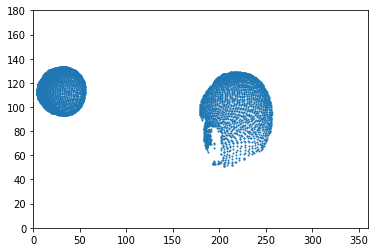

In [19]:
plt.scatter((phi_points*180/np.pi+ini_ph)%360,th_points*180/np.pi,s=1)
plt.xlim(0,360)
plt.ylim(0,180)
#plt.savefig('poles_pos_2rem.png')

In [ ]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(800, 800))
mlab.clf()
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:30j, 0.0:2.0*pi:30j]
rr = 2.0
x1 = rr*sin(phi)*cos(theta) 
y1 = rr*sin(phi)*sin(theta)
z1 = rr*cos(phi)
mlab.mesh(x1,y1,z1,opacity=0.7,color=(0.176, 0.521, 0.941))


#x1 = r_em*np.sin(135/180*np.pi)*np.cos(275/180*np.pi)
#y1 = r_em*np.sin(135/180*np.pi)*np.sin(275/180*np.pi)
#z1 = r_em*np.cos(135/180*np.pi)
x11 = x1.flatten()
y11 = y1.flatten()
z11 = z1.flatten()
opfl = []

for i in range(len(x_em_points)):
    print (i)
    try:
        fx1,fy1,fz1,opfl = numerically_find_flow_line_3d((x_em_points[i],y_em_points[i],z_em_points[i]), 0.1, opfl)
        mlab.plot3d(fx1, fy1, fz1, line_width=1.5, tube_radius=0.02, color=(0,0,0))
    except:
        pass

mlab.show()

In [ ]:
print ((opfl[0]))

In [ ]:
x_em_points = []
y_em_points = []
z_em_points = []
for i in range(len(opfl)):
    x_em_points.append(opfl[i][0])
    y_em_points.append(opfl[i][1])
    z_em_points.append(opfl[i][2]) 

In [ ]:
x_em_points = np.array(x_em_points)
y_em_points = np.array(y_em_points)
z_em_points = np.array(z_em_points)
rr = np.sqrt(x_em_points**2+y_em_points**2+z_em_points**2)
th_points = np.arccos(z_em_points/rr)
phi_points = np.arctan2(y_em_points,x_em_points)
phi_points = rescale_phi(phi_points)

In [ ]:
plt.scatter(phi_points*180/np.pi,th_points*180/np.pi)
plt.xlim(0,360)
plt.ylim(0,180)

In [14]:
dir = 'Data/Multipole/'
x_em_points,y_em_points,z_em_points = np.genfromtxt(dir+"openfieldlines_rem_5.txt",unpack=True)

In [15]:
rr = np.sqrt(x_em_points**2+y_em_points**2+z_em_points**2)
th_points = np.arccos(z_em_points/rr)
phi_points = np.arctan2(y_em_points,x_em_points)
#rr = np.sqrt(pp1**2+pp2**2+pp3**2)
#th_points = np.arccos(pp3/rr)
#phi_points = np.arctan(pp2/pp1)
phi_points = rescale_phi(phi_points)

(0.0, 180.0)

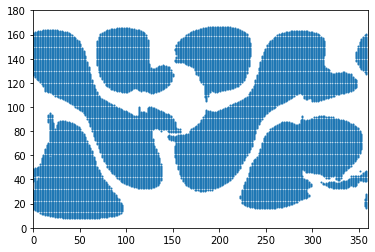

In [16]:
plt.scatter((phi_points*180/np.pi)%360,th_points*180/np.pi,s=1)
plt.xlim(0,360)
plt.ylim(0,180)